#0.0 IMPORTS

In [1]:
import warnings
import random
import requests
import json
import math
import pickle
import os

import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import scipy.stats         as stats
import xgboost             as xgb

from sklearn.preprocessing     import LabelEncoder,RobustScaler,MinMaxScaler
from sklearn.ensemble          import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model      import LinearRegression,Lasso,LogisticRegression
from tabulate                  import tabulate
from IPython.display           import Image
from sklearn.model_selection   import train_test_split
from sklearn.svm               import SVC,SVR
from sklearn                   import tree,metrics
from sklearn.neighbors         import KNeighborsClassifier 
from sklearn.naive_bayes       import GaussianNB,BernoulliNB
from flask                     import Flask, request,Response
from sklearn.feature_selection import RFE
from sklearn.metrics           import roc_curve, auc,accuracy_score
from sklearn.metrics           import precision_score, recall_score, f1_score
from imblearn.under_sampling   import NearMiss
from sklearn.model_selection   import StratifiedKFold,cross_val_predict
from sklearn.metrics           import confusion_matrix 
from sklearn.model_selection   import RandomizedSearchCV

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

##0.1 Helper Functions

In [2]:
def split_and_balancing(y,x,response):

  #split into train and test
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=2811)

  #NearMiss
  nr=NearMiss()
  x_train_nm,y_train_nm=nr.fit_resample(x_train,y_train)
  x_test_nm,y_test_nm=nr.fit_resample(x_test,y_test)

  #Concat
  aux1=pd.DataFrame(data=x_train_nm,columns=x_train.columns)
  aux1[response]=y_train_nm

  aux2=pd.DataFrame(data=x_test_nm,columns=x_test.columns)
  aux2[response]=y_test_nm

  df=pd.concat([aux1,aux2],axis=0)

  #split
  y=df[response]
  x=df.drop([response,'index','Id'],axis=1)

  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=2811)

  return [x_train,x_test,y_train,y_test]


def graph_of_levels(data,feature):

  lista=[]
  lista2=['medium','high','very_high']

  for i in range(0,len(lista2)):

    #healthy
    aux1=df4[df4[feature]==lista2[i]]
    aux2=aux1.shape[0]

    #sick
    aux3=aux1[aux1['Cardio']=='yes']
    aux4=aux3.shape[0]

    #percentage
    lista.append((aux4/aux2)*100)

  labels=lista2
  valores=lista

  ax=sns.barplot(x=labels, y=valores)
  ax.figure.set_size_inches(8,4)
  ax.set_title('Percentage of sick people by levels of {}'.format(feature)) 
   
  return ax


def numeric_correlation(numerics,data):

  columns=numerics.columns
  aux=data[columns]

  correlation=aux.corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);
  ax.figure.set_size_inches(10,5)
  ax.set_title('Correlation between numerical features',fontsize=14)

  return ax


def model_performance(y_test,yhat,name):

  dataframe=pd.DataFrame({ 'ModelName':    name,                                                                                                   
                           'Precision':    precision_score(y_test,yhat),                           
                           'Recall':       recall_score(y_test,yhat),
                           'F1Score':      f1_score(y_test,yhat),
                           'Accuracy':     accuracy_score(y_test,yhat)
                         },index=[0])
  return dataframe


def cross_validation(data,kfold,model_name,model,variable_response):
  
  precision_list=[]
  f1_score_list=[]
  recall_list=[]
  accuracy_list=[]
  

  fim=[]
  inicio=[]  
  razao=data.index.max()/kfold
  for i in range(1,kfold+1):
    fim.append(round(razao*i,2))
    inicio.append(round((razao*i)-razao,2))

  for k in range(0,kfold):

    #Start and end  for validation
    validation_start=inicio[k]
    validation_end=fim[k]

    #Filtering in dataset
    aux=data[(data.index>=validation_start) & (data.index<=validation_end)]
    training=data.drop(aux.index,axis=0)
    validation=data[(data.index>=validation_start) & (data.index<=validation_end)]


    #Training and validation dataset

    #Training
    xtraining=training.drop([variable_response],axis=1)
    ytraining=training[variable_response]

    #Validation
    xvalidation=validation.drop([variable_response],axis=1)
    yvalidation=validation[variable_response]


    #model
    m=model.fit(xtraining,ytraining)

    #prediction
    yhat=m.predict(xvalidation)

    performaces=model_performance(yvalidation,yhat,model_name)
    
    #performance of each KFold iteration
    precision_list.append(performaces['Precision'])
    f1_score_list.append(performaces['F1Score'])
    recall_list.append(performaces['Recall'])
    accuracy_list.append(performaces['Accuracy'])
    


  return pd.DataFrame({ 'ModelName':     model_name,                        
                        'PrecisionCV':   np.round(np.mean(precision_list),2).astype(str)+ '+/-' + np.round(np.std(precision_list),2).astype(str),
                        'RecallCV':      np.round(np.mean(recall_list),2).astype(str)+ '+/-'    + np.round(np.std(recall_list),2).astype(str),
                        'F1ScoreCV':     np.round(np.mean(f1_score_list),2).astype(str)+ '+/-' +  np.round(np.std(f1_score_list),2).astype(str),                        
                        'AccuracyCV':    np.round(np.mean(accuracy_list),2).astype(str)+ '+/-' +  np.round(np.std(accuracy_list),2).astype(str)
                       
                        },index=[0])
  

def categorical_correlation(data):

  #selected
  a=data.select_dtypes(include='object')

  #list one , all correlations
  columns=a.columns
  lista=[]
  for i2 in range(0,len(columns)):
    for i in range(0,len(columns)):
      lista.append(cramer_v(a[columns[i2]],a[columns[i]]))

  #list two , correlations by features
  lista2=[]
  n_features=len(columns)
  for i in range(0,n_features):

    a=n_features*i
    b=n_features*(i+1)

    lista2.append(lista[a:b])
  
  return lista2



def descriptive_statistics(data):

  #selected
  num_attributes=data.select_dtypes(include=['int64','float64'])

  #Central tendency=mean,median
  ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
  ct2=pd.DataFrame(num_attributes.apply(np.median)).T

  # Dispersion=std,min,max,range,skew,kurtosis
  d1=pd.DataFrame(num_attributes.apply(np.std)).T
  d2=pd.DataFrame(num_attributes.apply(min)).T
  d3=pd.DataFrame(num_attributes.apply(max)).T
  d4=pd.DataFrame(num_attributes.apply(lambda x:x.mean()-x.min())).T
  d5=pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
  d6=pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

  #Concatenate
  aux=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
  aux.columns=(['Attributes','Min','Max','range','Mean','Median','Std','Skew','kurtosis']) 

  return aux


def cramer_v(x,y):
  
  cm=pd.crosstab(x, y).to_numpy()
  n=cm.sum()
  r,k=cm.shape
  chi2=stats.chi2_contingency(cm)[0]
  chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
  kcorr=k-(k-1)**2/(n-1)
  rcorr=r-(r-1)**2/(n-1)

  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


def frequency_chart(response,feature2,data):

  plt.subplot(1,2,1)
  aux=data[data[response]=='yes']
  ax=sns.countplot(aux[feature2])
  ax.set_title('Healthy')
  ax.figure.set_size_inches(8,4)

  plt.subplot(1,2,2)
  aux=df4[df4[response]=='no']
  ax=sns.countplot(aux[feature2])
  ax.set_title('Sick')

  return ax


def plot_numeric_categorical(feature,feature_response,data):
  
  plt.subplot(2,2,1)
  ax=sns.barplot(x=feature_response,y=feature,data=df4)
  ax.figure.set_size_inches(12,6)

  plt.subplot(2,2,2)
  sns.boxplot(x=feature_response,y=feature,data=df4)

  plt.subplot(2,2,3)
  numeric_categorical(feature,feature_response,df4)

  return ax


def numeric_categorical(feature,feature_response,data):

  aux=data.copy()
  aux[feature_response]=aux[feature_response].apply(lambda x: 1 if x=='yes' else 0)
  correlation=aux[[feature,feature_response]].corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);

  return ax

##0.2 Loading Data

In [3]:
df_raw=pd.read_csv('/content/cardio_train.csv',sep=';')
df_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.00,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.00,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.00,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.00,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.00,100,60,1,1,0,0,0,0


# 1.0. DESCRIPTION OF THE DATA

In [4]:
df1=df_raw.copy()

##1.1 Rename Columns

In [5]:
columns={  'id':'Id','age':'Age','gender':'Gender','height':'Height',
           'weight':'Weight','ap_hi':'ApHi','ap_lo':'ApLo',
           'cholesterol':'Cholesterol','gluc':'Gluc','smoke':'Smoke',
           'alco':'Alco','active':'Active','cardio':'Cardio'}

df1.rename(columns=columns,inplace=True)

##1.2 Data Dimensions

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 70000
Number of cols: 13


##1.3 Data Types

In [7]:
df1.dtypes

Id               int64
Age              int64
Gender           int64
Height           int64
Weight         float64
ApHi             int64
ApLo             int64
Cholesterol      int64
Gluc             int64
Smoke            int64
Alco             int64
Active           int64
Cardio           int64
dtype: object

##1.4 Check NA

In [8]:
df1.isna().sum()

Id             0
Age            0
Gender         0
Height         0
Weight         0
ApHi           0
ApLo           0
Cholesterol    0
Gluc           0
Smoke          0
Alco           0
Active         0
Cardio         0
dtype: int64

##1.5 Change types

In [9]:
aux=['Gender','Smoke','Alco','Active','Cholesterol','Gluc','Cardio']
df1[aux]=df1[aux].astype(str)

##1.6 Rewriting the variables

In [10]:
levels={'1':'medium','2':'high','3':'very_high'} 
status={'1':'yes','0':'no'}
gender={'1':'woman','2':'man'}

#Cholesterol
df1['Cholesterol']=df1['Cholesterol'].map(levels)

#Gluc
df1['Gluc']=df1['Gluc'].map(levels)

#Smoke
df1['Smoke']=df1['Smoke'].map(status)

#Alco
df1['Alco']=df1['Alco'].map(status)

#Active
df1['Active']=df1['Active'].map(status)

#Cardio
df1['Cardio']=df1['Cardio'].map(status)

#Gender
df1['Gender']=df1['Gender'].map(gender)

#Age
df1['Age']=df1['Age']/365

#Height
df1['Height']=df1['Height']/100

In [11]:
#ApHi
df1['ApHi']=df1['ApHi'].apply(lambda x: x*(-1) if x<0 else x)
df1=df1[df1['ApHi']<200]

In [12]:
#AApLo
df1['ApLo']=df1['ApLo'].apply(lambda x: x*(-1) if x<0 else x)
df1=df1[df1['ApLo']<200]

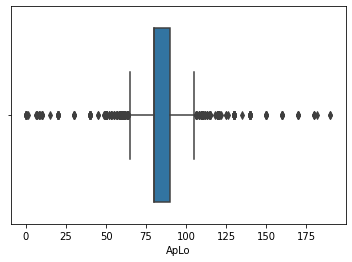

In [13]:
sns.boxplot(df1['ApLo'])

##1.7 Descriptive Statistical

In [14]:
num_attributes=df1.select_dtypes(include=['int64','float64'])
num_attributes.drop(['Id'],axis=1,inplace=True)

cat_attributes=df1.select_dtypes(include=['object'])

###1.7.1 Numerical Attributes

In [15]:
#Descriptive statistics
descriptive_statistics(num_attributes)

,Attributes,Min,Max,range,Mean,Median,Std,Skew,kurtosis
0,Age,29.58,64.97,23.74,53.32,53.97,6.76,-0.30,-0.83
1,Height,0.55,2.50,1.09,1.64,1.65,0.08,-0.65,8.07
2,Weight,11.00,200.00,63.09,74.09,72.00,14.30,1.00,2.53
3,ApHi,7.00,197.00,119.15,126.15,120.00,17.33,-0.06,4.98
4,ApLo,0.00,190.00,81.26,81.26,80.00,9.74,0.27,5.48


###1.7.2 Categorical attributes


In [16]:
#number of classes per feature
cat_attributes.apply(lambda x: x.unique().shape[0])

Gender         2
Cholesterol    3
Gluc           3
Smoke          2
Alco           2
Active         2
Cardio         2
dtype: int64

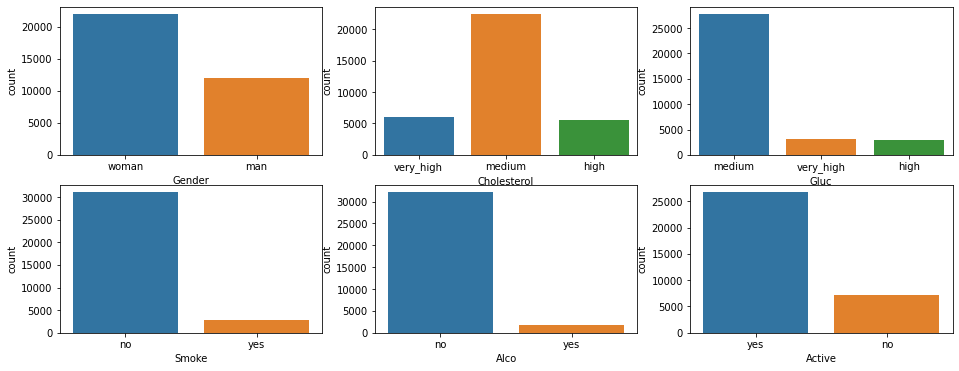

In [17]:
#Plot of categorical features 
sick=df1[df1['Cardio']=='yes']
columns=cat_attributes.columns[:6]

for i in range(0,6):
  plt.subplot(2,3,i+1)
  ax=sns.countplot(x=columns[i], data=sick)
  ax.figure.set_size_inches(16,6)

#2.0. FEATURE ENGINEERING

In [18]:
df2=df1.copy()

##2.1 Hypothesis mind map

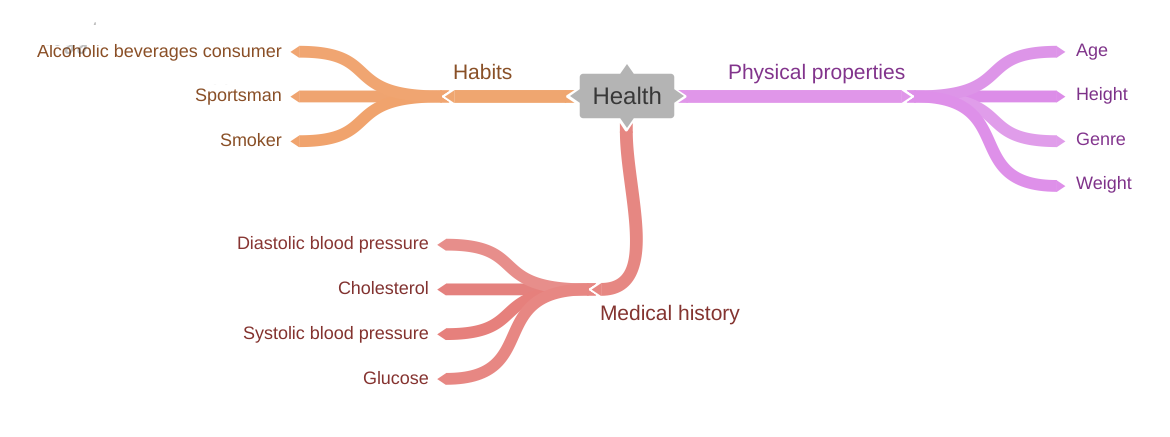

In [19]:
Image('/content/Health.png')

##2.2 Creation of hypotheses

### 2.1.1 Habits

**1.** Sportspersons are less prone to heart disease.

**2.** Smokers are more prone to heart disease.

 **3.** Alcoholic beverage consumers are more prone to heart disease.

### 2.1.2 Physical properties

**1.** Smaller people are more prone to heart disease.

**2.** Pessoas com o gênero masculino tem maior propensão a doenças cardíacas.

 **3.** Older people are more prone to heart disease.

**4.** People with high body weight are more prone to heart disease.

### 2.1.3 Medical history

**1.** People with high cholesterol are more prone to heart disease.

**2.** People with high systolic blood pressure are more prone to heart disease.

 **3.** People with high diastolic blood pressure are more prone to heart disease.

**4.** People with high blood glucose are more prone to heart disease.

##2.3 Final list of hypotheses

**H1-**.Players of sports are less prone to heart disease.

**H2-**.Smokers are more prone to heart disease.

**H3-**.Consumers of alcoholic beverages are more prone to heart disease.

**H4-**.People of shorter stature are more prone to heart disease.

**H5-**.People with the male gender are more prone to heart disease.

**H6-**. People with advanced age are more prone to heart disease.

**H7-**.People with high body weight are more prone to heart disease.

**H8-**.People with high cholesterol are more prone to heart disease.

**H9-**.People with high systolic blood pressure are more prone to heart disease.

**H10-**.People with high diastolic blood pressure are more prone to heart disease.

**H11-**.People with high glucose are more prone to heart disease.

##2.4 Feature Engineering

In [20]:
#ApHiLevel
df2['ApHiLevel']=df2['ApHi'].apply(lambda x:'level1' if x<80 else 'level2' if (x>=80)&(x<140) else 'level3')

#ApLoLevel
df2['ApLoLevel']=df2['ApLo'].apply(lambda x:'level1' if x<70 else 'level2' if (x>=75)&(x<100) else 'level3')

#WeightLevel
df2['WeightLevel']=df2['Weight'].apply(lambda x: 'level1' if x<50 else 'level2'if (x>=50)&(x<=80) else 'level3')

#AgeLevel
df2['AgeLevel']=df2['Age'].apply(lambda x : 'level1' if x<45 else'level2' if (x>=45)&(x<60) else 'level3')

#Imc
df2['Imc']=df2['Weight']/(df2['Height']**2)

#3.0. VARIABLES FILTERING

In [21]:
df3=df2.copy()

##3.1. Line Filtering

In [22]:
#ApHi
aphi_mean=df3['ApHi'].mean()
df3['ApHi']=df3['ApHi'].apply(lambda x: aphi_mean if x<100 else  aphi_mean if x>200 else x)

#ApLo
aplo_mean=df3['ApLo'].mean()
df3['ApLo']=df3['ApLo'].apply(lambda x: aplo_mean if x<75 else  aplo_mean if x>100 else x)

#Weight
weight_mean=df3['Weight'].mean()
df3['Weight']=df3['Weight'].apply(lambda x: weight_mean if x<40 else  x)

#Height
height_mean=df3['Height'].mean()
df3['Height']=df3['Height'].apply(lambda x: height_mean if x<1.25  else x)
df3=df3.reset_index()

#4.0. EXPLORATORY DATA ANALYSIS

In [23]:
df4=df3.copy()

## 4.1 Univariate Analysis

###4.1.1. Response Variable

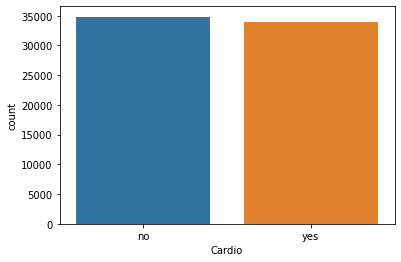

In [24]:
ax=sns.countplot(df4['Cardio'])

###4.1.2. Numerical Variable

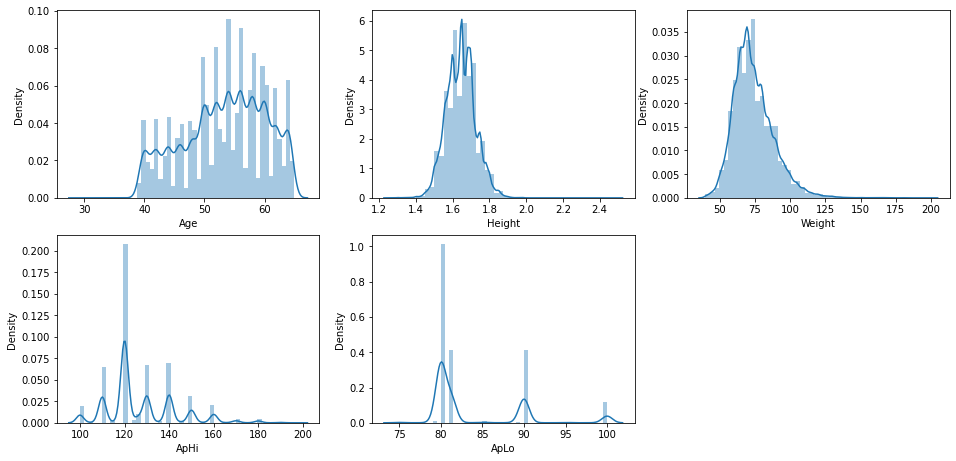

In [25]:
#plot of numerical features
columns=num_attributes.columns

for i in range(0,len(columns)):

  plt.subplot(len(columns),3,i+1)
  ax=sns.distplot(df4[columns[i]])  
  ax.figure.set_size_inches(16,20)

###4.1.3. Categorical Variable

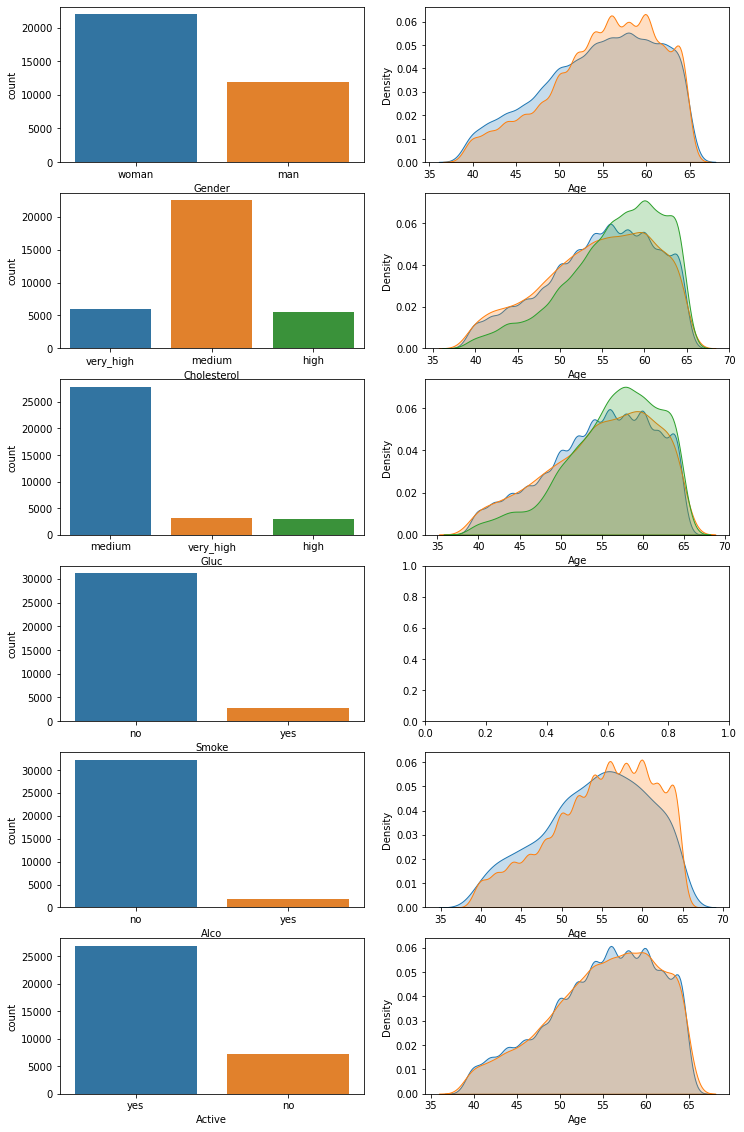

In [26]:
sick=df4[df4['Cardio']=='yes']
healthy=df4[df4['Cardio']=='no']

#Genero
plt.subplot(6,2,1)
ax=sns.countplot(sick['Gender'])
ax.figure.set_size_inches(12,20)

plt.subplot(6,2,2)
ax=sns.kdeplot(sick[sick['Gender']=='man']['Age'],label='Gender',shade=True)
ax=sns.kdeplot(sick[sick['Gender']=='woman']['Age'],label='Gender',shade=True)

#Cholesterol
plt.subplot(6,2,3)
ax=sns.countplot(sick['Cholesterol'])

plt.subplot(6,2,4)
ax=sns.kdeplot(sick[sick['Cholesterol']=='medium']['Age'],label='Cholesterol',shade=True)
ax=sns.kdeplot(sick[sick['Cholesterol']=='high']['Age'],label='Cholesterol',shade=True)
ax=sns.kdeplot(sick[sick['Cholesterol']=='very_high']['Age'],label='Cholesterol',shade=True)

#Gluc
plt.subplot(6,2,5)
ax=sns.countplot(sick['Gluc'])

plt.subplot(6,2,6)
ax=sns.kdeplot(sick[sick['Gluc']=='medium']['Age'],label='Gender',shade=True)
ax=sns.kdeplot(sick[sick['Gluc']=='high']['Age'],label='Gender',shade=True)
ax=sns.kdeplot(sick[sick['Gluc']=='very_high']['Age'],label='Gender',shade=True)

#Smoke
plt.subplot(6,2,7)
ax=sns.countplot(sick['Smoke'])

plt.subplot(6,2,8)
ax=sns.kdeplot(sick[sick['Smoke']=='Age']['Age'],label='Age',shade=True)
ax=sns.kdeplot(sick[sick['Smoke']=='Age']['Age'],label='Gender',shade=True)

#Alco
plt.subplot(6,2,9)
ax=sns.countplot(sick['Alco'])

plt.subplot(6,2,10)
ax=sns.kdeplot(sick[sick['Alco']=='yes']['Age'],label='Age',shade=True)
ax=sns.kdeplot(sick[sick['Alco']=='no']['Age'],label='Age',shade=True)

#Active
plt.subplot(6,2,11)
ax=sns.countplot(sick['Active'])

plt.subplot(6,2,12)
ax=sns.kdeplot(sick[sick['Active']=='yes']['Age'],label='Gender',shade=True)
ax=sns.kdeplot(sick[sick['Active']=='no']['Age'],label='Gender',shade=True)

## 4.2 Bivariate Analysis

### ***H1***. Players of sports are less prone to heart disease.(False-Low)

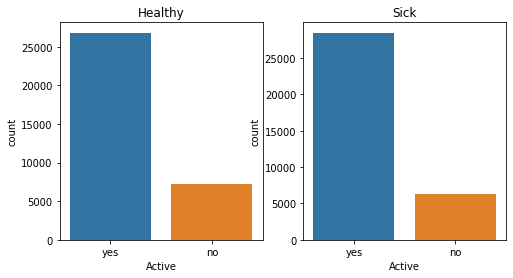

In [27]:
frequency_chart('Cardio','Active',df4)

### ***H2***. Smokers are more prone to heart disease.(False-Low)


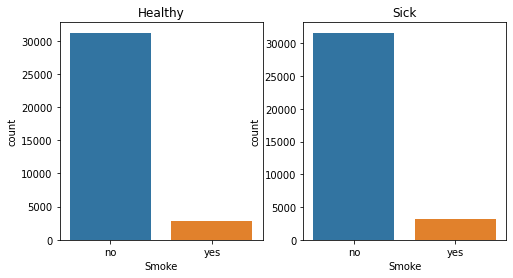

In [28]:
frequency_chart('Cardio','Smoke',df4)

### ***H3***. Consumers of alcoholic beverages are more prone to heart disease.(FALSE-Low)

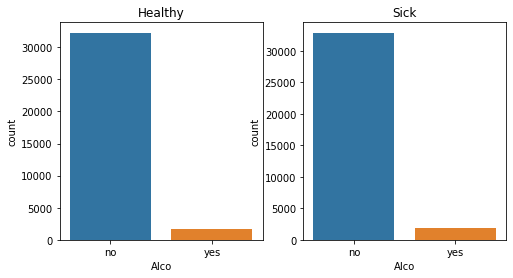

In [29]:
frequency_chart('Cardio','Alco',df4)

### ***H4***. People of shorter stature are more prone to heart disease.(FALSE-Low)

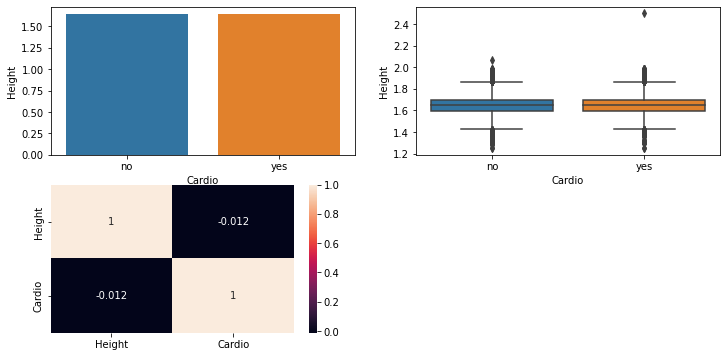

In [30]:
plot_numeric_categorical('Height','Cardio',df4)

### ***H5***. People with the male gender are more prone to heart disease.(FALSE-Low)


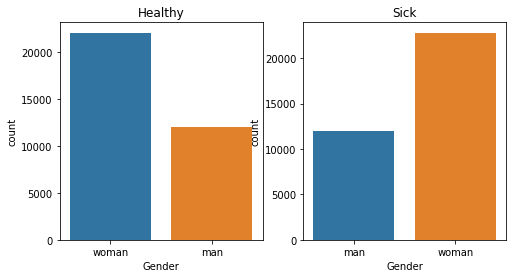

In [31]:
frequency_chart('Cardio','Gender',df4)

### ***H6***. People with advanced age are more prone to heart disease.(TRUE-Medium)


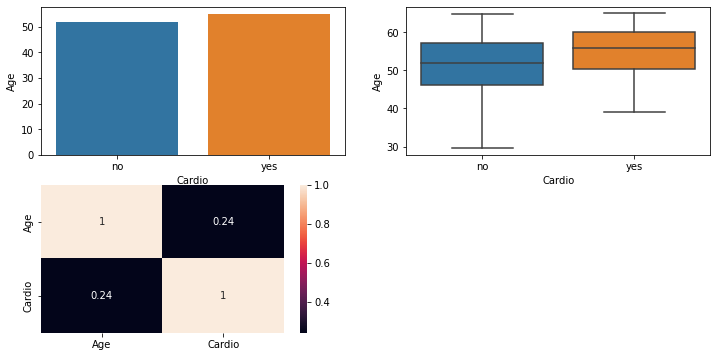

In [32]:
plot_numeric_categorical('Age','Cardio',df4)

### ***H7***. People with high body weight are more prone to heart disease.(TRUE-Low)

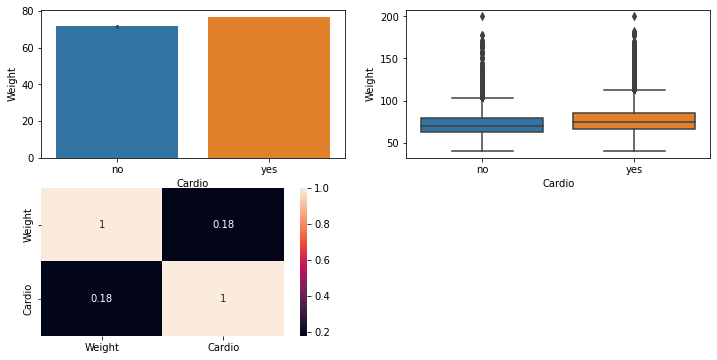

In [33]:
plot_numeric_categorical('Weight','Cardio',df4)

### ***H8***. People with high cholesterol are more prone to heart disease.(TRUE-High)

Text(0.5, 1.0, 'Percentage of people sick by cholesterol levels')

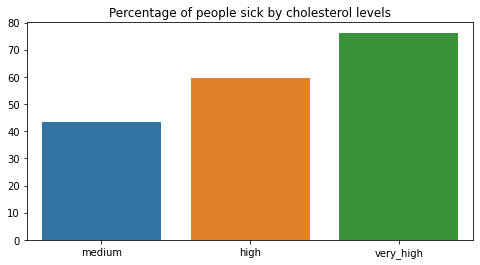

In [34]:
#Calculation of the percentage of sick people by cholesterol levels
lista=[]
lista2=['medium','high','very_high']

for i in range(0,len(lista2)):

  #healphy
  aux1=df4[df4['Cholesterol']==lista2[i]]
  aux2=aux1.shape[0]

  #sick
  aux3=aux1[aux1['Cardio']=='yes']
  aux4=aux3.shape[0]

  #Percentage
  lista.append((aux4/aux2)*100)

#plot
labels=lista2
valores=lista

ax=sns.barplot(x=labels, y=valores)
ax.figure.set_size_inches(8,4)
ax.set_title('Percentage of people sick by cholesterol levels')

### ***H9***. People with high systolic blood pressure are more prone to heart disease.(TRUE-High)

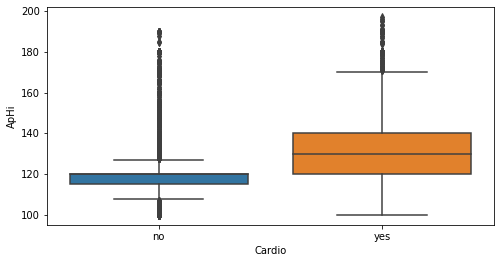

In [35]:
ax=sns.boxplot(x='Cardio', y='ApHi',data=df4)       
ax.figure.set_size_inches(8,4) 

### ***H10***. People with high diastolic blood pressure are more prone to heart disease.(TRUE-medium)

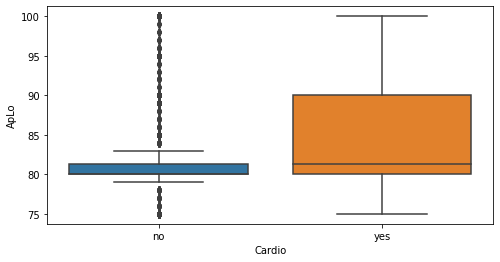

In [36]:
ax=sns.boxplot(x='Cardio', y='ApLo',data=df4)       
ax.figure.set_size_inches(8,4) 

### ***H11***. People with high glucose are more prone to heart disease.(TRUE-High)

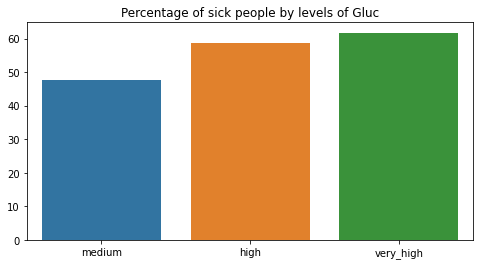

In [37]:
graph_of_levels(df4,'Gluc')

### 4.2.1 Summary of hypotheses

In [38]:
tab=[['Hypotheses','Status'  ,'Relevance'],
     ['H1'        ,'False'   ,'low'],
     ['H2'        ,'False'   ,'low'],
     ['H3'        ,'False'   ,'low'],
     ['H4'        ,'False'   ,'low'],
     ['H5'        ,'True'    ,'medium'],
     ['H6'        ,'True'    ,'low'],
     ['H7'        ,'True'    ,'low'],
     ['H8'        ,'True'    ,'right'],
     ['H9'        ,'True'    ,'right'],
     ['H10'       ,'True'    ,'medium'],
     ['H11'       ,'True'    ,'high']]

print(tabulate(tab,headers='firstrow'))

Hypotheses    Status    Relevance
------------  --------  -----------
H1            False     low
H2            False     low
H3            False     low
H4            False     low
H5            True      medium
H6            True      low
H7            True      low
H8            True      right
H9            True      right
H10           True      medium
H11           True      high


## 4.3 Multivariate Analysis

###4.3.1. Numerical Atributes

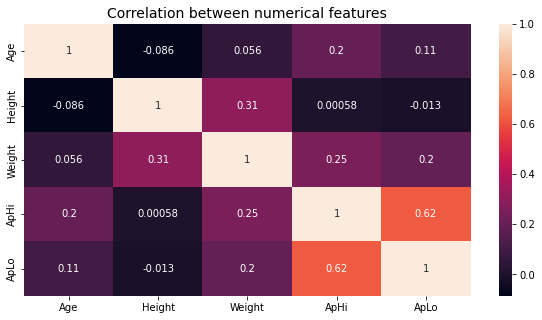

In [39]:
numeric_correlation(num_attributes,df4)

###4.3.2. Categorical Atributes

In [40]:
lista=categorical_correlation(df4)

d=pd.DataFrame({'Gender':       lista[0],
                'Cholesterol':  lista[1],
                'Gluc':         lista[2],
                'Smoke':        lista[3],
                'Alco':         lista[4],
                'Active':       lista[5],
                'Cardio':       lista[6],
                'ApHiLevel':    lista[7],
                'ApLoLevel':    lista[8],
                'WeightLevel':  lista[9],
                'AgeLevel':     lista[10]
                })

d=d.set_index(d.columns)

d

,Gender,Cholesterol,Gluc,Smoke,Alco,Active,Cardio,ApHiLevel,ApLoLevel,WeightLevel,AgeLevel
Gender,1.00,0.04,0.02,0.34,0.17,0.00,0.01,0.03,0.05,0.12,0.03
Cholesterol,0.04,1.00,0.39,0.02,0.04,0.01,0.22,0.13,0.04,0.09,0.09
Gluc,0.02,0.39,1.00,0.02,0.03,0.01,0.09,0.07,0.02,0.07,0.06
Smoke,0.34,0.02,0.02,1.00,0.34,0.03,0.02,0.02,0.01,0.06,0.04
Alco,0.17,0.04,0.03,0.34,1.00,0.03,0.01,0.02,0.01,0.06,0.03
Active,0.00,0.01,0.01,0.03,0.03,1.00,0.04,0.01,0.01,0.02,0.01
Cardio,0.01,0.22,0.09,0.02,0.01,0.04,1.00,0.41,0.12,0.15,0.22
ApHiLevel,0.03,0.13,0.07,0.02,0.02,0.01,0.41,1.00,0.08,0.13,0.10
ApLoLevel,0.05,0.04,0.02,0.01,0.01,0.01,0.12,0.08,1.00,0.08,0.07
WeightLevel,0.12,0.09,0.07,0.06,0.06,0.02,0.15,0.13,0.08,1.00,0.03


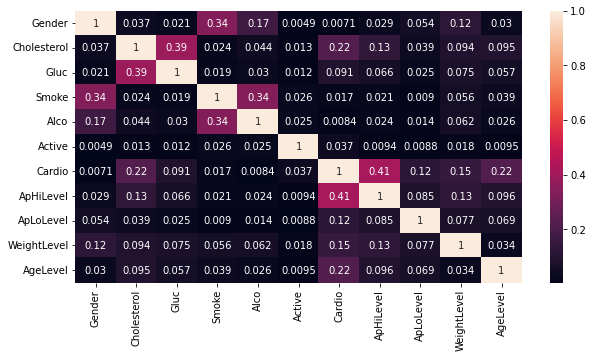

In [41]:
#Heatmap
ax=sns.heatmap(d,annot=True)
ax.figure.set_size_inches(10,5)

#5.0. DATA PREPARATION

In [42]:
df5=df4.copy()

##5.1. Rescaling

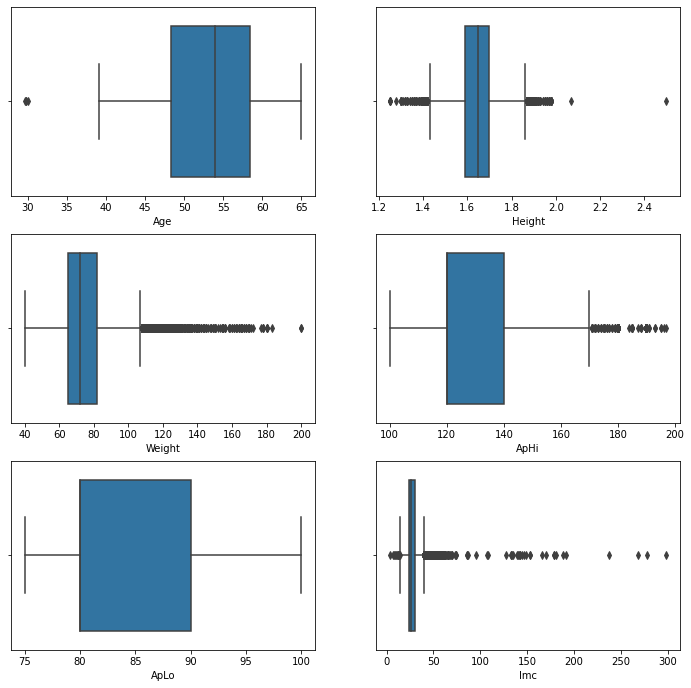

In [43]:
#viewing outliers
num_attributes=pd.concat([df5[num_attributes.columns],df5['Imc']],axis=1)
columns=num_attributes.columns

for i in range(0,len(columns)):

  plt.subplot(4,2,i+1)
  ax=sns.boxplot(num_attributes[columns[i]])
  ax.figure.set_size_inches(12,16)

In [44]:
mms=MinMaxScaler()
rs=RobustScaler()

#MinMaxScaler
#Age
df5['Age']=np.log1p(df5['Age'])


#ApLo
df5['ApLo']=np.log1p(df5['ApLo'])


#RobustScaler
#Height
df5['Height']=rs.fit_transform(df5[['Height']].values)
pickle.dump(rs,open('/content/Height_scaler.pkl','wb'))

#Weight
df5['Weight']=rs.fit_transform(df5[['Weight']].values)
pickle.dump(rs,open('/content/Weight_scaler.pkl','wb'))

#ApHi
df5['ApHi']=np.log1p(df5['ApHi'])

#Imc
df5['Imc']=rs.fit_transform(df5[['Imc']].values)
pickle.dump(rs,open('/content/Imc_scaler.pkl','wb'))

## 5.2. Transformation

###5.2.1. Encoding

In [45]:
#OneHotEncoder
#Gender
df5=pd.get_dummies(df5,prefix=['Gender'],columns=['Gender'])

#Smoke
df5=pd.get_dummies(df5,prefix=['Smoke'],columns=['Smoke'])

#Alco
df5=pd.get_dummies(df5,prefix=['Alco'],columns=['Alco'])

#Active
df5=pd.get_dummies(df5,prefix=['Active'],columns=['Active'])

#LabelEncoder
#Cardio
le=LabelEncoder()
df5['Cardio']=le.fit_transform(df5['Cardio'])

#OrdinalEncoder
#Cholesterol
assortment_dict={'medium':1,'high':2,'very_high':3}
df5['Cholesterol']=df5['Cholesterol'].map(assortment_dict)

#Gluc
assortment_dict={'medium':1,'high':2,'very_high':3}
df5['Gluc']=df5['Gluc'].map(assortment_dict)

#ApLoLevel
assortment_dict={'level1':1,'level2':2,'level3':3}
df5['ApLoLevel']=df5['ApLoLevel'].map(assortment_dict)

#WeightLevel
assortment_dict={'level1':1,'level2':2,'level3':3}
df5['WeightLevel']=df5['WeightLevel'].map(assortment_dict)

#AgeLevel
assortment_dict={'level1':1,'level2':2,'level3':3}
df5['AgeLevel']=df5['AgeLevel'].map(assortment_dict)

#ApHiLevel
assortment_dict={'level1':1,'level2':2,'level3':3}
df5['ApHiLevel']=df5['ApHiLevel'].map(assortment_dict)

#6.0. FEATURE SELECTION

In [46]:
df6=df5.copy()

In [47]:
df6.head(2)

,index,Id,Age,Height,Weight,ApHi,ApLo,Cholesterol,Gluc,Cardio,ApHiLevel,ApLoLevel,WeightLevel,AgeLevel,Imc,Gender_man,Gender_woman,Smoke_no,Smoke_yes,Alco_no,Alco_yes,Active_no,Active_yes
0,0,0,3.94,0.27,-0.59,4.71,4.39,1,1,0,2,2,2,2,-0.70,1,0,1,0,1,0,0,1
1,1,1,4.03,-0.82,0.76,4.95,4.51,3,1,1,3,2,3,2,1.37,0,1,1,0,1,0,0,1


##6.1. Split dataframe into training and test dataset.

In [48]:
df6=df6[df6.index <69500]

#Train and test
Y_train=df6['Cardio']
X_train=df6.drop(['Cardio',],axis=1)
x_train,x_test,y_train,y_test=split_and_balancing(Y_train,X_train,'Cardio')

#Dataset cross validation
aux1=pd.DataFrame(data=y_train,columns=['Cardio'])
aux1=pd.concat([x_train,aux1],axis=1)
aux2=pd.DataFrame(data=y_test,columns=['Cardio'])
aux2=pd.concat([x_test,aux2],axis=1)
df6=pd.concat([aux1.reset_index(drop=True), aux2.reset_index(drop=True)], axis= 0)

##6.2. RFE as feature selector


In [49]:
'''svr = SVR(kernel="linear")
selector = RFE(svr, n_features_to_select=1, step=1).fit(x_train, y_train)'''

'svr = SVR(kernel="linear")\nselector = RFE(svr, n_features_to_select=1, step=1).fit(x_train, y_train)'

##6.2.1. Best Features from RFE

In [50]:
'''x_train.columns'''

'x_train.columns'

In [51]:
'''selector.ranking_'''

'selector.ranking_'

In [52]:
 #['ApHiLevel','Cholesterol','ApLo','ApHi','AgeLevel','Age']

##6.3. Manual Feature selection


In [53]:
cols_selected_rfe=['ApHiLevel','Cholesterol','ApLo','ApHi','AgeLevel','Age']

#Columns to add
feat_to_add=['Cardio']
cols_selected_rfe_full=cols_selected_rfe.copy()
cols_selected_rfe_full.extend(feat_to_add)

#7.0. MACHINE LEARNING MODELLING

In [54]:
#Copy
df7=df6[cols_selected_rfe_full].copy()

#Ativar as colunas 
x_train=x_train[cols_selected_rfe]
x_test=x_test[cols_selected_rfe]

##7.1. Baseline

In [55]:
#Prediction
yhat_rendom=np.ones(len(y_test))

#Performance
baseline_result=model_performance(y_test,yhat_rendom,'Baseline')
baseline_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,Baseline,0.50,1.00,0.66,0.50


##7.2. SVM

In [56]:
#Model
svc = SVC(gamma="auto")
svc_train=svc.fit(x_train,y_train)

#Prediction
yhat_svc=svc_train.predict(x_test)

#Performance
svc_result=model_performance(y_test,yhat_svc,'SVM')
svc_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,SVM,0.75,0.65,0.70,0.72


###7.2.1 SVM cross validation

In [57]:
svc_result_cv=cross_validation(df7,5,'SVM',svc,'Cardio')
svc_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,SVM,0.75+/-0.0,0.65+/-0.0,0.7+/-0.0,0.72+/-0.0


##7.3. Random Forest Classifier

In [58]:
#Model
rfc=RandomForestClassifier(max_depth=2, random_state=0)
rfc_train=rfc.fit(x_train,y_train)

#Predict
yhat_rfc=rfc_train.predict(x_test)

#Performance
rfc_result=model_performance(y_test,yhat_rfc,'RandomForestClassifier')
rfc_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,RandomForestClassifier,0.78,0.61,0.69,0.72


###7.3.1 Random Forest Classifier cross validation

In [59]:
rfc_result_cv=cross_validation(df7,5,'RandomForestClassifier',rfc,'Cardio')
rfc_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,RandomForestClassifier,0.78+/-0.01,0.61+/-0.0,0.69+/-0.0,0.72+/-0.0


##7.4. Logistic Regression

In [60]:
#Model
lr= LogisticRegression(random_state=0)
lr_train=lr.fit(x_train,y_train)

#Predict
yhat_lr=lr_train.predict(x_test)

#Performance
lr_result=model_performance(y_test,yhat_lr,'Logistic Regression')
lr_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,Logistic Regression,0.78,0.62,0.69,0.73


###7.4.1 Logistic Regression cross validation

In [61]:
lr_result_cv=cross_validation(df7,5,'Logistic Regression',lr,'Cardio')
lr_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,Logistic Regression,0.78+/-0.0,0.62+/-0.0,0.69+/-0.0,0.72+/-0.0


##7.5. KNeighbors Classifier 


In [62]:
#Model
knn = KNeighborsClassifier(n_neighbors=5)
knn_train=knn.fit(x_train,y_train)

#Prediction
yhat_knn=knn_train.predict(x_test)

#Performance
knn_result=model_performance(y_test,yhat_knn,'KNeighbors Classifier')
knn_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,KNeighbors Classifier,0.69,0.69,0.69,0.70


###7.5.1 KNeighbors Classifier cross validation

In [63]:
knn_result_cv=cross_validation(df7,5,'KNeighbors Classifier',knn,'Cardio')
knn_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,KNeighbors Classifier,0.7+/-0.0,0.68+/-0.0,0.69+/-0.0,0.69+/-0.0


##7.6. Naive Bayes Gaussian

In [64]:
#Model
gau = GaussianNB()
gau_train=gau.fit(x_train,y_train)

#Prediction
yhat_gau=gau_train.predict(x_test)

#Performance
gau_result=model_performance(y_test,yhat_gau,'Naive Bayes Gaussian')
gau_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,Naive Bayes Gaussian,0.79,0.60,0.68,0.72


###7.6.1 Naive Bayes Gaussian cross validation

In [65]:
gau_result_cv=cross_validation(df7,5,'Naive Bayes Gaussian',gau,'Cardio')
gau_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,Naive Bayes Gaussian,0.79+/-0.0,0.59+/-0.0,0.68+/-0.0,0.72+/-0.0


##7.7. XGBClassifier

In [66]:
#Model
xgbc= xgb.XGBClassifier()
xgbc_train=xgbc.fit(x_train,y_train)

#Prediction
yhat_xgbc=xgbc_train.predict(x_test)

#Performance
xgbc_result=model_performance(y_test,yhat_xgbc,'XGBClassifier')
xgbc_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,XGBClassifier,0.75,0.70,0.72,0.73


###7.7.1 XGBClassifier cross validation

In [67]:
xgbc_result_cv=cross_validation(df7,5,'XGBClassifier',xgbc,'Cardio')
xgbc_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,XGBClassifier,0.75+/-0.0,0.69+/-0.0,0.72+/-0.0,0.73+/-0.0


##7.8. Compare Model's Performance

###7.8.1. Single Performance


In [68]:
modelling_results=pd.concat([svc_result,rfc_result,lr_result,knn_result,gau_result,xgbc_result],axis=0)
modelling_results.sort_values('F1Score',ascending=False)

,ModelName,Precision,Recall,F1Score,Accuracy
0,XGBClassifier,0.75,0.70,0.72,0.73
0,SVM,0.75,0.65,0.70,0.72
0,Logistic Regression,0.78,0.62,0.69,0.73
0,KNeighbors Classifier,0.69,0.69,0.69,0.70
0,RandomForestClassifier,0.78,0.61,0.69,0.72
0,Naive Bayes Gaussian,0.79,0.60,0.68,0.72


###7.8.2. Real Performance - Cross Validation


In [69]:
modelling_results_cv=pd.concat([svc_result_cv,rfc_result_cv,lr_result_cv,knn_result_cv,gau_result_cv,xgbc_result_cv],axis=0)
modelling_results_cv.sort_values('F1ScoreCV',ascending=False)

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,XGBClassifier,0.75+/-0.0,0.69+/-0.0,0.72+/-0.0,0.73+/-0.0
0,SVM,0.75+/-0.0,0.65+/-0.0,0.7+/-0.0,0.72+/-0.0
0,RandomForestClassifier,0.78+/-0.01,0.61+/-0.0,0.69+/-0.0,0.72+/-0.0
0,Logistic Regression,0.78+/-0.0,0.62+/-0.0,0.69+/-0.0,0.72+/-0.0
0,KNeighbors Classifier,0.7+/-0.0,0.68+/-0.0,0.69+/-0.0,0.69+/-0.0
0,Naive Bayes Gaussian,0.79+/-0.0,0.59+/-0.0,0.68+/-0.0,0.72+/-0.0


#8.0. HYPERPARAMETER FINE TUNING

In [70]:
df8=df7.copy()

##8.1.Random Search

In [71]:
'''params={'n_estimators':      [500,1000,1500,1700,2500,3000,3500],
        'eta':               [0.01,0.03,0.06],
        'max_depth':         [2,4,6,8,10,12],
        'subsample':         [0.1,0.5,0.7],
        'colsample_bytree':  [0.3,0.7,0.9],
        'min_child_weight':  [3,6,9,12,15]}

#model
model_xgb=xgb.XGBClassifier()

rscv = RandomizedSearchCV(model_xgb, params, random_state=0,cv=3,n_iter=100).fit(x_train, y_train)
rscv.best_params_'''

"params={'n_estimators':      [500,1000,1500,1700,2500,3000,3500],\n        'eta':               [0.01,0.03,0.06],\n        'max_depth':         [2,4,6,8,10,12],\n        'subsample':         [0.1,0.5,0.7],\n        'colsample_bytree':  [0.3,0.7,0.9],\n        'min_child_weight':  [3,6,9,12,15]}\n\n#model\nmodel_xgb=xgb.XGBClassifier()\n\nrscv = RandomizedSearchCV(model_xgb, params, random_state=0,cv=3,n_iter=100).fit(x_train, y_train)\nrscv.best_params_"

In [72]:
'''{'colsample_bytree': 0.7,
              'eta':              0.03,
              'max_depth':        2,
              'min_child_weight': 12,
              'n_estimators':     1500,
              'subsample':        0.5}'''

"{'colsample_bytree': 0.7,\n              'eta':              0.03,\n              'max_depth':        2,\n              'min_child_weight': 12,\n              'n_estimators':     1500,\n              'subsample':        0.5}"

##8.2.Final Model

In [73]:
#Params tuned
params_tuned={'colsample_bytree': 0.7,
              'eta':              0.03,
              'max_depth':        2,
              'min_child_weight': 12,
              'n_estimators':     1500,
              'subsample':        0.5}


#Model
xgb_tuned=xgb.XGBClassifier(         objective=         'reg:squarederror',
                                     n_estimators=      params_tuned['n_estimators'],
                                     eta=               params_tuned['eta'],
                                     max_depth=         params_tuned['max_depth'],
                                     subsample=         params_tuned['subsample'],
                                     colsample_bytree=  params_tuned['colsample_bytree'],
                                     min_child_weight=  params_tuned['min_child_weight'])
                                
#Prediction
xgb_tuned_train_final=xgb_tuned.fit(x_train,y_train)
yhat_xgb_tuned=xgb_tuned_train_final.predict(x_test)

#Performance
xgbc_result=model_performance(y_test,yhat_xgb_tuned,'XGBClassifier')
xgbc_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,XGBClassifier,0.75,0.69,0.72,0.73


In [74]:
#Save trained model
pickle.dump(xgb_tuned_train_final,open('xgb_tuned_train_final.pkl','wb'))

#9.0. TRANSLATION AND INTERPRETATION OF THE ERROR

In [75]:
df9=df8.copy()

##9.1.Machine Learning Performance

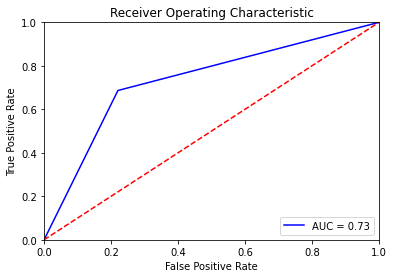

In [76]:
#AUC Curve
fpr, tpr, threshold = metrics.roc_curve(y_test, yhat_xgb_tuned)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

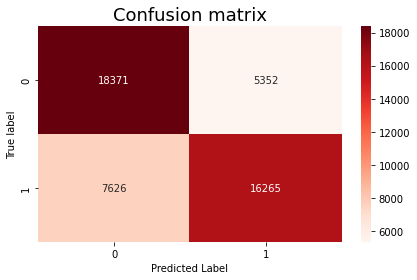

In [77]:
#Confusion matrix
np.random.seed(2811)

cv = StratifiedKFold(n_splits = 5, shuffle = True)
y_pred = cross_val_predict(xgb_tuned , x_train, y_train, cv = cv)


fig, ax = plt.subplots()
ax=sns.heatmap(confusion_matrix(y_train, y_pred), annot=True,ax=ax, fmt='d', cmap='Reds')
ax.set_title("Confusion matrix", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

##9.2.Business Performance

###Perguntas a serem respondidas:

####1-Qual e a Precisão da ferramenta?

In [78]:
xgbc_result

,ModelName,Precision,Recall,F1Score,Accuracy
0,XGBClassifier,0.75,0.69,0.72,0.73


####2-Quanto lucro a Cardio Catch Diseases passará a ter com a nova ferramenta?

In [79]:
current_precision=50
precision_xgb=accuracy_score(y_test,yhat_xgb_tuned)*100
diagnostic_price=1000
preco_accuracy=100

profit=((precision_xgb-current_precision))*preco_accuracy
print('Profit with the new diagnostic tool: R$ {}'.format(profit))

Profit with the new diagnostic tool: R$ 2334.1174164461436


#10.0. DEPLOY MODEL TO PRODUCTION

##10.0. App Streamlit

In [80]:
'''import streamlit as st 
import json
import requests
import pandas as pd

@st.cache()
  
# function input
def prediction(Cholesterol,ApLo,ApHi,Age):
  #Create dataframe
  d = {'Cholesterol':[Cholesterol],'ApLo':[ApLo],'ApHi':[ApHi],'Age':[Age]}
  df = pd.DataFrame(data=d)

  #converter em json
  df=json.dumps(df.to_dict(orient='records'))

  #API call
  path='https://sdbfsdfbqqqqq.herokuapp.com/'
  url=path +'oi'
  headers={'content-type':'application/json'}  
  r=requests.post(url,data=df,headers=headers)

  #Prediction
  df=pd.DataFrame(r.json(),columns=r.json()[0].keys())

  a=df['Predictions'][0]
  if a==1:
    b='Sick'
  elif a==0:
    b='Healthy'
  else: 
    b='ERRO DE PREDICAO'
        
  return b
      
  
# webapp  
def main():       
    # Config web
    html_temp = """ 
    <div style ="background-color:gray;padding:13px"> 
    <h1 style ="color:black;text-align:center;">Diagnóstico precoce cardiovascular</h1> 
    </div> 
    """
      
    # display 
    st.markdown(html_temp, unsafe_allow_html = True) 
      
    # Imput
    Cholesterol = st.selectbox('Nível de colesterol',('1','2','3'))
    ApLo =        st.number_input('Pressão diastólica')
    ApHi =        st.number_input('Pressão sistólica')      
    Age =         st.number_input('Idade') 

    result =""
      
    # Predict 
    if st.button("Predict"):        
        result = prediction(Cholesterol,ApLo,ApHi,Age) 
        st.success('Estado de saúde: {}'.format([Cholesterol,ApLo,ApHi,Age]))
        
     
if __name__=='__main__': 
    main()'''

'import streamlit as st \nimport json\nimport requests\nimport pandas as pd\n\n@st.cache()\n  \n# function input\ndef prediction(Cholesterol,ApLo,ApHi,Age):\n  #Create dataframe\n  d = {\'Cholesterol\':[Cholesterol],\'ApLo\':[ApLo],\'ApHi\':[ApHi],\'Age\':[Age]}\n  df = pd.DataFrame(data=d)\n\n  #converter em json\n  df=json.dumps(df.to_dict(orient=\'records\'))\n\n  #API call\n  path=\'https://sdbfsdfbqqqqq.herokuapp.com/\'\n  url=path +\'oi\'\n  headers={\'content-type\':\'application/json\'}  \n  r=requests.post(url,data=df,headers=headers)\n\n  #Prediction\n  df=pd.DataFrame(r.json(),columns=r.json()[0].keys())\n\n  a=df[\'Predictions\'][0]\n  if a==1:\n    b=\'Sick\'\n  elif a==0:\n    b=\'Healthy\'\n  else: \n    b=\'ERRO DE PREDICAO\'\n        \n  return b\n      \n  \n# webapp  \ndef main():       \n    # Config web\n    html_temp = """ \n    <div style ="background-color:gray;padding:13px"> \n    <h1 style ="color:black;text-align:center;">Diagnóstico precoce cardiovascular</h

##10.1. transformations class

In [81]:
'''import pandas as pd
import numpy  as np
import pickle


class transformations (object):  
     
  def data_cleaning(self,df1):  
    df1=df1.copy()
    #Change types    
    df1['Cholesterol']=df1['Cholesterol'].astype(str)

    #Rewriting the variables
    niveis={'1':'medium','2':'high','3':'very_high'} 
    estado={'1':'yes','0':'no'}    

    #Cholesterol
    df1['Cholesterol']=df1['Cholesterol'].map(niveis)   
    
    return df1
  
  
  def feature_engeneering(self,df2):
    df2=df2.copy()

    #ApHiLevel
    df2['ApHiLevel']=df2['ApHi'].apply(lambda x:'level1' if x<80 else 'level2' if (x>=80)&(x<140) else 'level3')

    #ApLoLevel
    df2['ApLoLevel']=df2['ApLo'].apply(lambda x:'level1' if x<70 else 'level2' if (x>=75)&(x<100) else 'level3')
    
    #AgeLevel
    df2['AgeLevel']=df2['Age'].apply(lambda x : 'level1' if x<45 else'level2' if (x>=45)&(x<60) else 'level3')
   
    #ApHi
    aphi_mean=df2['ApHi'].mean()
    df2['ApHi']=df2['ApHi'].apply(lambda x: aphi_mean if x<100 else  aphi_mean if x>200 else x)

    #ApLo
    aplo_mean=df2['ApLo'].mean()
    df2['ApLo']=df2['ApLo'].apply(lambda x: aplo_mean if x<75 else  aplo_mean if x>100 else x)
    

    return df2  
  

  def data_preparation(self,df5):
    df5=df5.copy()
    
    #Age
    df5['Age']=np.log1p(df5['Age'])
    
    #ApLo
    df5['ApLo']=np.log1p(df5['ApLo'])
            
    #ApHi
    df5['ApHi']=np.log1p(df5['ApHi'])     
    
             
    #Cholesterol
    assortment_dict={'medium':1,'high':2,'very_high':3}
    df5['Cholesterol']=df5['Cholesterol'].map(assortment_dict)    

    #ApLoLevel
    assortment_dict={'level1':1,'level2':2,'level3':3}
    df5['ApLoLevel']=df5['ApLoLevel'].map(assortment_dict)
  
    #AgeLevel
    assortment_dict={'level1':1,'level2':2,'level3':3}
    df5['AgeLevel']=df5['AgeLevel'].map(assortment_dict)

    #ApHiLevel
    assortment_dict={'level1':1,'level2':2,'level3':3}
    df5['ApHiLevel']=df5['ApHiLevel'].map(assortment_dict)
    
    
    df5=df5[['ApHiLevel','Cholesterol','ApLo','ApHi','AgeLevel','Age']]    
    
    return df5

  
  def get_prediction(self, model, dado_original, data_transforme):

    #prediction
    pred=model.predict(data_transforme)

    #join pred into the original data
    dado_original['Predictions']=pred 

    return  dado_original.to_json(orient='records',date_format='iso')'''    

"import pandas as pd\nimport numpy  as np\nimport pickle\n\n\nclass transformations (object):  \n     \n  def data_cleaning(self,df1):  \n    df1=df1.copy()\n    #Change types    \n    df1['Cholesterol']=df1['Cholesterol'].astype(str)\n\n    #Rewriting the variables\n    niveis={'1':'medium','2':'high','3':'very_high'} \n    estado={'1':'yes','0':'no'}    \n\n    #Cholesterol\n    df1['Cholesterol']=df1['Cholesterol'].map(niveis)   \n    \n    return df1\n  \n  \n  def feature_engeneering(self,df2):\n    df2=df2.copy()\n\n    #ApHiLevel\n    df2['ApHiLevel']=df2['ApHi'].apply(lambda x:'level1' if x<80 else 'level2' if (x>=80)&(x<140) else 'level3')\n\n    #ApLoLevel\n    df2['ApLoLevel']=df2['ApLo'].apply(lambda x:'level1' if x<70 else 'level2' if (x>=75)&(x<100) else 'level3')\n    \n    #AgeLevel\n    df2['AgeLevel']=df2['Age'].apply(lambda x : 'level1' if x<45 else'level2' if (x>=45)&(x<60) else 'level3')\n   \n    #ApHi\n    aphi_mean=df2['ApHi'].mean()\n    df2['ApHi']=df2['ApHi']

##10.2. API Handler

In [82]:
'''from flask                           import Flask,request,Response
from transformations.transformations import transformations
import os
import pickle
import pandas              as pd


#Loading model
model=pickle.load(open('model/xgb_tuned_train_final.pkl','rb'))

#Initialize API
app=Flask(__name__)

@app.route('/oi',methods=['POST'])
def diagnostico_predict():
  test_json=request.get_json()

  if test_json:
    if isinstance (test_json,dict):
      test_raw=pd.DataFrame(test_json,index=[0])

    else:
      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
    
    #Isntantiate transformations
    pipeline=transformations()  

    #data cleaning
    df1=pipeline.data_cleaning(test_raw)  

    #feature engeneering
    df2=pipeline.feature_engeneering(df1)

    #data preparation
    df3=pipeline.data_preparation(df2)

    #predict
    df_response=pipeline.get_prediction(model,test_raw,df3)
    
    return df_response

  else:
    return Response('{}',status=200,mimetype='application/json')

if __name__ == "__main__":
    port = int(os.environ.get("PORT", 5000))
    app.run(host='0.0.0.0', port=port)'''

'from flask                           import Flask,request,Response\nfrom transformations.transformations import transformations\nimport os\nimport pickle\nimport pandas              as pd\n\n\n#Loading model\nmodel=pickle.load(open(\'model/xgb_tuned_train_final.pkl\',\'rb\'))\n\n#Initialize API\napp=Flask(__name__)\n\n@app.route(\'/oi\',methods=[\'POST\'])\ndef diagnostico_predict():\n  test_json=request.get_json()\n\n  if test_json:\n    if isinstance (test_json,dict):\n      test_raw=pd.DataFrame(test_json,index=[0])\n\n    else:\n      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())\n    \n    #Isntantiate transformations\n    pipeline=transformations()  \n\n    #data cleaning\n    df1=pipeline.data_cleaning(test_raw)  \n\n    #feature engeneering\n    df2=pipeline.feature_engeneering(df1)\n\n    #data preparation\n    df3=pipeline.data_preparation(df2)\n\n    #predict\n    df_response=pipeline.get_prediction(model,test_raw,df3)\n    \n    return df_response\n\n  else:

##10.3.API Tester

In [83]:
#Dataframe de teste do deploy
d=df_raw[df_raw.index>=69500].reset_index()
df=d.drop(['cardio'],axis=1)

columns={  'id':'Id','age':'Age','gender':'Gender','height':'Height',
           'weight':'Weight','ap_hi':'ApHi','ap_lo':'ApLo',
           'cholesterol':'Cholesterol','gluc':'Gluc','smoke':'Smoke',
           'alco':'Alco','active':'Active','cardio':'Cardio'}

df=df.rename(columns=columns)
df=df[['Cholesterol','ApLo','ApHi','Age']]
df['Age']=df['Age']/365


#converter em json
df=json.dumps(df.to_dict(orient='records'))

#API call
path='https://sdnfsdnfttttt.herokuapp.com/'
url=path +'oi'
headers={'content-type':'application/json'}
data=df
r=requests.post(url,data=data,headers=headers)
print('Status code {}'.format(r.status_code))

Status code 200


In [84]:
#Prediction
df1=pd.DataFrame(r.json(),columns=r.json()[0].keys())
df1

,Cholesterol,ApLo,ApHi,Age,Predictions
0,1,90,130,56.68,1
1,1,90,150,47.83,1
2,1,80,120,64.40,1
3,1,80,120,55.58,0
4,1,80,180,63.93,1
...,...,...,...,...,...
495,1,80,120,52.71,0
496,2,90,140,61.92,1
497,3,90,180,52.24,1
498,1,80,135,61.45,1
